In [ ]:
# default_exp statistics

In [17]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preprocess

In [2]:
from convert_timemap.core import get_files
fs = get_files(head=None)

In [3]:
import os
import pandas as pd
from tqdm import tqdm

df = pd.DataFrame()
# fs.sort(key=os.path.getsize, reverse=True)

for f in tqdm(fs):
    with open(f) as js:
        data = pd.read_json(js)
        df = df.append(data, ignore_index=True)

100%|██████████| 31925/31925 [1:13:54<00:00,  7.20it/s]


In [ ]:
df.to_pickle('./all.pkl')

### if you already have the pkl, don't run the above! it will take a while. uncomment the lines below instead

In [2]:
import pickle
with open('all.pkl', 'rb') as f:
    df = pickle.load(f)

In [3]:
df['coordinates'].head(100)

0     {'lat': 26.229584, 'lon': 50.496015}
1        {'lat': 26.1567, 'lon': 50.66749}
2       {'lat': 26.14344, 'lon': 50.60415}
3       {'lat': 26.11736, 'lon': 50.63323}
4        {'lat': 26.1567, 'lon': 50.66749}
                      ...                 
95    {'lat': 26.284306, 'lon': 50.629184}
96    {'lat': 26.284306, 'lon': 50.629184}
97    {'lat': 26.284306, 'lon': 50.629184}
98    {'lat': 26.284306, 'lon': 50.629184}
99    {'lat': 26.284306, 'lon': 50.629184}
Name: coordinates, Length: 100, dtype: object

# Analysis

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [21]:
df.columns

Index(['targetId', 'investigationId', 'coordinates', 'locationType',
       'lastSpotted', 'startTime', 'endTime'],
      dtype='object')

## Number of points per target

In [44]:
print(f"Total number of points: {len(df)}")

targets = df['targetId'].value_counts()
print(f"Number of targets: {len(vcs_all)}")
print(f"Mean: {targets.mean()}")
print(f"Mode: {targets.mode()}")
print(f"Median: {targets.median()}")
print(f"Standard deviation: {targets.std()}")

Total number of points: 564282
Number of targets: 31925
Mean: 17.67523884103367
Mode: 0    1
dtype: int64
Median: 4.0
Standard deviation: 76.78930513861103


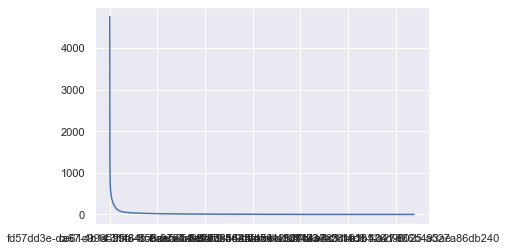

In [48]:
targets.plot(kind="line")

In [60]:
targets.head(5000)[-1]

20

Take out the top 5000 targets, and all other ~27k targets have 20 or less points.

In [63]:
print(f"Top target has {targets[0]} points")

Top target has 4754 points


In [91]:
top5k = targets.head(5000)
top5k = top5k.to_frame()
top5k['noPoints'] = top5k['targetId']
top5k['targetId'] = top5k.index
top5k = top5k.reset_index(drop=True)

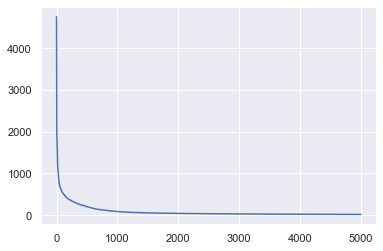

In [109]:
sns.lineplot(data=top5k['noPoints'])

                                targetId  noPoints
99  4aaa26fd-6ad4-4d4f-a230-569de0af373a       548


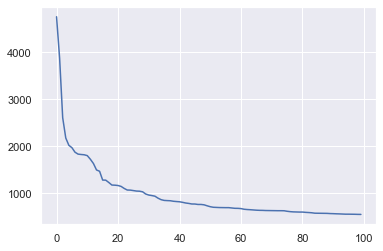

In [111]:
top100 = top5k.head(100)
print(top100.tail(1))
sns.lineplot(data=top100['noPoints'])

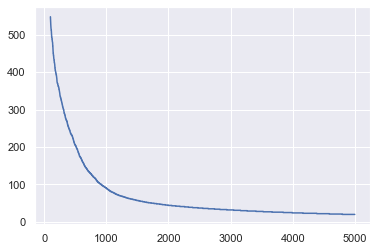

In [107]:
top5kless100 = top5k[100:]
sns.lineplot(data=top5kless100['noPoints'])

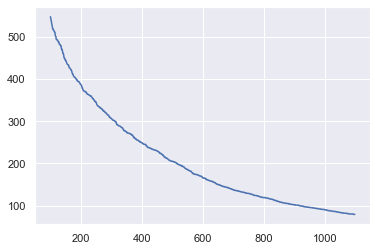

In [108]:
top1kless100 = top5kless100[:1000]
sns.lineplot(data=top1kless100['noPoints'])

## Pruning heavies

In [167]:
top1kless100

,targetId,noPoints
100,fb395fc2-7dc4-4cb8-bd11-26aba9fde301,548
101,ab189089-e842-43ba-b287-0db28b5b2a15,545
102,3adc3050-cca5-4af7-845a-04863c37cf5d,540
103,3859510b-3f89-43a4-8989-66a9b1066bf1,538
104,feb3aaf8-5b35-4afc-bfef-55c9632b44b1,532
...,...,...
1095,08748ee3-3ade-4bba-a2d9-0da53ef5b666,79
1096,269c74c8-c5fe-4d93-827b-5c4ad2859db7,79
1097,f60aabcb-e005-4ae1-9155-22defd7b2c26,79
1098,3911eb69-0db5-4152-a377-ea6c2ddfb705,79


## Timeframe

In [125]:
from convert_timemap.core import dt

startTimes, endTimes = df['startTime'], df['endTime']
startTimes, endTimes = startTimes.dropna(), endTimes.dropna()
minDate, maxDate = dt(startTimes.min()), dt(endTimes.max())

In [129]:
def nice_date(thedate):
    return datetime.strftime(thedate, '%m/%d/%Y')

In [130]:
nice_date(minDate), nice_date(maxDate)

('03/10/2020', '04/13/2020')

In [162]:
import numpy as np

newdf = df.copy()
newdf['timestamp'] = np.nan
newdf['timestamp'][pd.notnull(newdf['startTime'])] = newdf['startTime']
newdf['timestamp'][pd.notnull(newdf['lastSpotted'])] = newdf['lastSpotted']

def ext(key):
    def t(obj):
        return obj[key]
    return t
newdf['latitude'] = newdf['coordinates'].apply(ext('lat'))
newdf['longitude'] = newdf['coordinates'].apply(ext('lon'))

newdf = newdf.drop(columns=['startTime', 'endTime', 'lastSpotted', 'coordinates'])

/Users/lachlankermode/Library/Caches/pypoetry/virtualenvs/to-timemap-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [165]:
test = newdf.sample(n=100)
pd.get_dummies(test['targetId'], prefix="t_")

,t__023d53ad-9f4b-4416-ba71-f8a728188f71,t__030e5172-5c70-4e86-be6a-e8f90ff0a9e1,t__0b8288bc-ee91-420b-a96b-3535a388ebb1,t__0df7f932-7a9a-4be4-835d-1540fdb0be18,t__0eba492e-3e06-47b3-a648-902c023e0771,t__0ff124a8-576f-48b5-8f8f-6884a7aeb9fd,t__1170dad0-aff7-44a8-8a9f-4d6bda781ba6,t__156295d6-c75c-4603-9f39-a8417163283e,t__16cebca1-64ef-46f2-b2ee-12b32be27db8,t__16d965f0-eb6a-45bb-9cfc-d1ac0f2ab0db,...,t__e34e5ddf-b33f-415e-a954-2f0e0896acaf,t__e4cd1e36-b00d-41e7-b3b8-db407d80c79d,t__eb8e9802-a961-406b-a928-4de263e97624,t__ec6b6960-9180-4a83-a565-5e6f4f70ad2e,t__ed039980-beca-4757-a076-2decb9631452,t__f8bad9f1-b6a1-4cbb-a3d8-698bb9464126,t__f924bece-1fc1-42bf-b22c-194288b30f63,t__faaa422f-bf27-4d36-a7a7-dea6f6972d10,t__fbee95be-846c-4fc1-92b9-c2075821f036,t__fd57dd3e-da67-4b14-9f46-8c5aabe54e8a
123256,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
510065,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61215,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
43166,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
189430,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205821,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
46177,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
261342,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9898,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [174]:
df[df['targetId'] == "b83344f3-303f-4e31-a909-c53ea8b01c4b"]

,targetId,investigationId,coordinates,locationType,lastSpotted,startTime,endTime,timestamp
194649,b83344f3-303f-4e31-a909-c53ea8b01c4b,COVID19___country-SAU_20200331_145940,"{'lat': 26.279399, 'lon': 50.2083}",regionPoint,NaN,2020-03-11T11:48:45Z,2020-03-11T11:48:45Z,NaN
194650,b83344f3-303f-4e31-a909-c53ea8b01c4b,COVID19___country-SAU_20200331_145940,"{'lat': 24.468599, 'lon': 39.614199}",regionPoint,NaN,2020-03-11T11:48:46Z,2020-03-11T11:48:46Z,NaN
194651,b83344f3-303f-4e31-a909-c53ea8b01c4b,COVID19___country-SAU_20200331_145940,"{'lat': 24.6537, 'lon': 46.7152}",lastLocation,2020-03-18T08:55:01Z,NaN,NaN,NaN


In [175]:
df

,targetId,investigationId,coordinates,locationType,lastSpotted,startTime,endTime,timestamp
0,0d1f5b02-3178-494b-a0c7-bbc171249e3f,COVID19___country-BHR_20200419_0713,"{'lat': 26.229584, 'lon': 50.496015}",lastLocation,2020-03-28T23:50:18Z,NaN,NaN,NaN
1,0d1f5b02-3178-494b-a0c7-bbc171249e3f,COVID19___country-BHR_20200419_0713,"{'lat': 26.1567, 'lon': 50.66749}",regionPoint,NaN,2020-03-26T11:44:03Z,2020-03-26T11:44:03Z,NaN
2,0d1f5b02-3178-494b-a0c7-bbc171249e3f,COVID19___country-BHR_20200419_0713,"{'lat': 26.14344, 'lon': 50.60415}",regionPoint,NaN,2020-03-26T15:30:48Z,2020-03-26T15:30:48Z,NaN
3,0d1f5b02-3178-494b-a0c7-bbc171249e3f,COVID19___country-BHR_20200419_0713,"{'lat': 26.11736, 'lon': 50.63323}",regionPoint,NaN,2020-03-21T21:16:28Z,2020-03-21T21:16:30Z,NaN
4,0d1f5b02-3178-494b-a0c7-bbc171249e3f,COVID19___country-BHR_20200419_0713,"{'lat': 26.1567, 'lon': 50.66749}",keyLocation,NaN,2020-03-26T11:44:03Z,2020-03-26T11:44:03Z,NaN
...,...,...,...,...,...,...,...,...
564277,3918f40c-b934-4ad5-b822-be048f1e5a5a,COVID19___country_IL_20200326_142406,"{'lat': 31.801468, 'lon': 34.6524}",meetingPlace,NaN,2020-03-18T00:43:01Z,2020-03-18T00:44:44Z,NaN
564278,3918f40c-b934-4ad5-b822-be048f1e5a5a,COVID19___country_IL_20200326_142406,"{'lat': 31.801438, 'lon': 34.652359}",meetingPlace,NaN,2020-03-18T00:40:42Z,2020-03-18T00:44:44Z,NaN
564279,3918f40c-b934-4ad5-b822-be048f1e5a5a,COVID19___country_IL_20200326_142406,"{'lat': 31.801473, 'lon': 34.652293}",meetingPlace,NaN,2020-03-18T00:34:42Z,2020-03-18T00:34:43Z,NaN
564280,3918f40c-b934-4ad5-b822-be048f1e5a5a,COVID19___country_IL_20200326_142406,"{'lat': 31.801469, 'lon': 34.652368}",meetingPlace,NaN,2020-03-18T00:34:42Z,2020-03-18T00:40:25Z,NaN
